## Lib

In [1]:
!pip install -q flwr[simulation]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 27.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 27.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.7 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires go

In [2]:
# Standard libraries
import os
import warnings
import math
import random
from pathlib import Path
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import IntEnum
import json

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from ipywidgets import interact

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# Torchvision
import torchvision.transforms as transforms

# Flower
import flwr
from flwr.client import Client, ClientApp
from flwr.common import (
    Code, EvaluateIns, EvaluateRes, FitIns, FitRes, GetParametersIns, GetParametersRes,
    Status, Parameters, Scalar, NDArray, NDArrays, ndarrays_to_parameters, parameters_to_ndarrays, Context
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.simulation import run_simulation

# HuggingFace Datasets
from datasets.utils.logging import disable_progress_bar, set_verbosity_error

2025-05-07 16:43:03.257590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746636183.664946      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746636183.779479      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup

In [3]:
# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()
warnings.filterwarnings("ignore")

# Định nghĩa drop out
class CustomCode(IntEnum):
    DROPPED_OUT = 100

Training on cuda
Flower 1.18.0 / PyTorch 2.5.1+cu124


In [28]:
# config
NUM_CLIENTS = 10
NUM_ROUNDS = 10
DROPOUT = 0.3
BATCHSIZE = 14
LR = 0.001
epochs_round = 1

## Prepare Data

In [5]:
im = nib.load('/kaggle/input/mri-dataset/not_skull_stripped/sub-BrainAge000000/anat/sub-BrainAge000000_T1w.nii/sub-BrainAge000000_T1w.nii')
data = im.get_fdata()
data.shape, im.affine, im.header

((130, 130, 130),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 <nibabel.nifti1.Nifti1Header at 0x793486e1dc50>)

In [6]:
def show_slice(slice_index):
    plt.imshow(data[slice_index, :, :], cmap='gray')
    plt.title(f"Axial Slice {slice_index}")
    plt.axis('off')
    plt.show()

interact(show_slice, slice_index=(0, data.shape[2] - 1));

interactive(children=(IntSlider(value=64, description='slice_index', max=129), Output()), _dom_classes=('widge…

In [7]:
data_dir = '/kaggle/input/mri-dataset/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [8]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]
len(label_ls)

8764

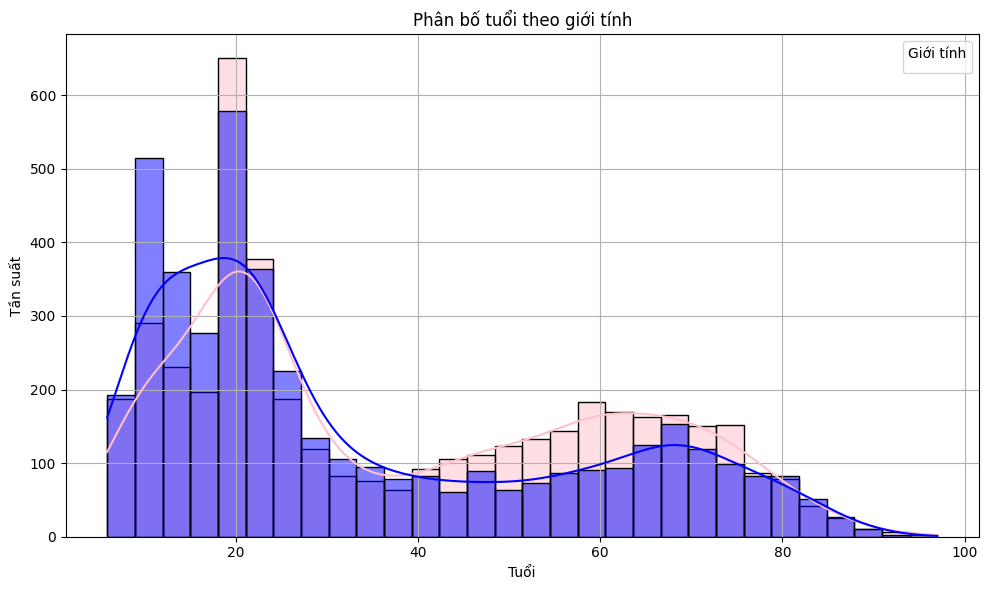

In [9]:
label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')
label_ls = label_ls.dropna(subset=['subject_age'])

plt.figure(figsize=(10, 6))

sns.histplot(data=label_ls, x="subject_age", hue="subject_sex", bins=30, kde=True, 
             palette={"m": "blue", "f": "pink"}, edgecolor="black", discrete=False)

plt.title('Phân bố tuổi theo giới tính')
plt.xlabel('Tuổi')
plt.ylabel('Tần suất')
plt.legend(title='Giới tính')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
subject_metadata = label_ls[['subject_sex','subject_id','dataset_name','subject_age']]
subject_metadata

,subject_sex,subject_id,dataset_name,subject_age
19,m,sub-BrainAge000019,ABIDE/Caltech,44.2
20,m,sub-BrainAge000020,ABIDE/Caltech,39.3
21,m,sub-BrainAge000021,ABIDE/Caltech,42.5
22,m,sub-BrainAge000022,ABIDE/Caltech,19.7
23,f,sub-BrainAge000023,ABIDE/Caltech,20.0
...,...,...,...,...
23209,f,sub-BrainAge023209,RocklandSample,66.0
23210,m,sub-BrainAge023210,RocklandSample,69.0
23211,m,sub-BrainAge023211,RocklandSample,23.0
23212,f,sub-BrainAge023212,RocklandSample,54.0


In [11]:
subject_metadata_dict = label_ls.set_index('subject_id')[['subject_sex','dataset_name','subject_age']].to_dict(orient='index')
len(subject_metadata_dict)

8717

In [12]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        if im_filenames is not None:
            self.im_filenames = im_filenames
        else:
            self.im_filenames = self._gather_valid_paths()

    def _gather_valid_paths(self):
        paths = self.im_dir.glob("*/*/*/*.nii")
        valid_paths = []
        fail_paths = {
            self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
        }

        for path in paths:
            if not path.is_file():
                continue
                
            if path in fail_paths:
                continue
                
            subject_id = self._extract_subject_id(path)
            if subject_id not in self.label_ls:
                continue
            try:
                # nib.load(path).get_fdata()
                nib.load(path)
                valid_paths.append(path)
            except Exception:
                continue
        return valid_paths

    def _extract_subject_id(self, path):
        for part in Path(path).parts:
            if part.startswith("sub-BrainAge"):
                return part  # ví dụ: "sub-BrainAge000000"
        return None

    def _normalize(self, im):
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
        return im.astype(np.float32)

    def _get_label(self, subject_id):
        sex = self.label_ls.get(subject_id, {}).get("subject_sex")
        if sex == 'm':
            return 0
        elif sex == 'f':
            return 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
            
    def _get_age(self, subject_id):
        return self.label_ls.get(subject_id, {}).get("subject_age")
    
    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        subject_id = self._extract_subject_id(im_path)

        im = nib.load(im_path).get_fdata()
        im = self._normalize(im)

        label = self._get_label(subject_id)
        image = torch.from_numpy(im).unsqueeze(0)  # Shape: (1, H, W, D)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [13]:
def create_global_bin_pool(data: MRIDataset) -> dict:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array([
        subject_metadata.get(sid, {}).get("subject_age", np.nan)
        for sid in subject_ids
    ], dtype=np.float32)

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)

    global_bin_pool = {}
    for bin_id in np.unique(age_bins):
        bin_indices = valid_indices[age_bins == bin_id]
        global_bin_pool[bin_id] = set(bin_indices.tolist())

    return global_bin_pool


def get_sample_data(
    data: MRIDataset,
    overlap: float,
    partition_id: int,
    num_partitions: int,
    global_bin_pool: dict,
    num_samples: int = None,
) -> list:
    subject_metadata = data.label_ls
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]

    age_array = np.array(
        [subject_metadata.get(sid, {}).get("subject_age", np.nan) for sid in subject_ids],
        dtype=np.float32
    )

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_bins = np.digitize(age_array, bins, right=False)
    total_samples = len(valid_indices)
    client_sample_count = total_samples // num_partitions

    rng = np.random.default_rng(seed=partition_id + 42)
    sampled_indices = set()
    used_bins = set()

    all_bins = list(global_bin_pool.keys())
    rng.shuffle(all_bins)
    target_num_bins = max(1, int(overlap * len(all_bins)))

    # Vòng lặp đến khi đủ sample
    while len(sampled_indices) < client_sample_count:
        # Chọn bin chưa dùng
        candidate_bins = [b for b in all_bins if b not in used_bins]
        if not candidate_bins:
            break  # Không còn bin nào để lấy

        selected_bins = candidate_bins[:target_num_bins]
        used_bins.update(selected_bins)

        # Lấy toàn bộ samples từ các bin đã chọn
        combined_indices = []
        for bin_id in selected_bins:
            available = global_bin_pool[bin_id]
            combined_indices.extend(list(available))

        rng.shuffle(combined_indices)

        # Chọn mẫu đến khi đủ
        needed = client_sample_count - len(sampled_indices)
        to_take = combined_indices[:needed]
        sampled_indices.update(to_take)

        # Xoá mẫu đã chọn khỏi global_bin_pool
        for idx in to_take:
            for bin_id in selected_bins:
                global_bin_pool[bin_id].discard(idx)

    if num_samples and num_samples > client_sample_count:
        remaining_needed = num_samples - client_sample_count
        remaining_pool = list(set(valid_indices) - sampled_indices)
        rng.shuffle(remaining_pool)
        extra = remaining_pool[:remaining_needed]
        sampled_indices.update(extra)

    return list(sampled_indices)

In [14]:
def load_client_datasets(partition_id: int, num_partitions: int, dataset, overlap: int, global_bin_pool: dict, num_samples=None):
    data = dataset
    sampled_indices = get_sample_data(data=data, overlap=overlap, partition_id=partition_id, num_partitions=num_partitions, 
                                      global_bin_pool=global_bin_pool, num_samples=num_samples)

    np.random.shuffle(sampled_indices)
    train_size = int(0.8 * len(sampled_indices))
    train_indices = sampled_indices[:train_size]
    val_indices = sampled_indices[train_size:]

    train_subset = Subset(data, train_indices)
    val_subset = Subset(data, val_indices)
    return train_subset, val_subset

In [15]:
def load_server_test_datasets(data: MRIDataset):
    testloader = DataLoader(data, batch_size=BATCHSIZE, shuffle=False)
    return testloader

In [16]:
def load_filenames(input_path):
    input_path = Path(input_path)
    if not input_path.is_file():
        raise FileNotFoundError(f"File {input_path} không tồn tại")
    with open(input_path, 'r') as f:
        return [Path(path) for path in json.load(f)]

In [17]:
im_filenames = load_filenames("/kaggle/input/federated-learning/valid_filenames.json")

In [18]:
dataset = MRIDataset(data_dir, subject_metadata_dict, im_filenames=im_filenames)
len(dataset)

4948

In [ ]:
# def save_filenames(im_filenames, output_path):
#     output_path = Path(output_path)
#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     with open(output_path, 'w') as f:
#         json.dump([str(path) for path in im_filenames], f)
#     print(output_path)

In [ ]:
# save_filenames(dataset.im_filenames, "valid_filenames.json")

In [19]:
from sklearn.model_selection import train_test_split

all_filenames = dataset.im_filenames

# Chia train/test 
train_filenames, test_filenames = train_test_split(
    all_filenames, test_size=0.2, random_state=42, shuffle=True
)

trainset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=train_filenames
)

testset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=test_filenames
)


In [32]:
global_bin_pool = create_global_bin_pool(trainset)

316


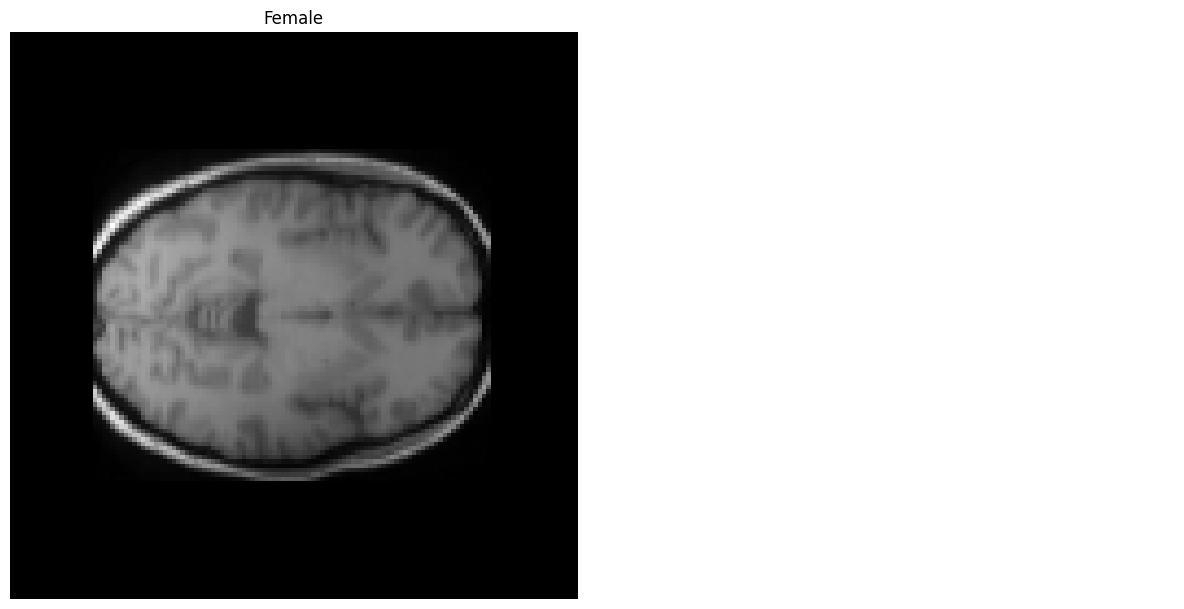

In [33]:
# train_subset, _ = load_client_datasets(partition_id=3, num_partitions=10, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
# print(len(train_subset))

# batch = next(iter(train_subset))
# images, labels = batch
# images = images.numpy()
# slice_idx = images.shape[3] // 2
# slices = images[:, :, :, slice_idx]

# class_names = ["Male", "Female"]
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# for i, ax in enumerate(axs.flat):
#     if i < len(slices):
#         ax.imshow(slices[i], cmap='gray')
#         ax.set_title(class_names[labels.item()])
#         ax.axis("off")
#     else:
#         ax.axis("off")

# plt.tight_layout()
# plt.show()

In [34]:
# def plot_age_distribution(subset):
#     dataset = subset.dataset
#     indices = subset.indices

#     data = []
#     for i in indices:
#         subject_id = dataset._extract_subject_id(dataset.im_filenames[i])
#         metadata = dataset.label_ls.get(subject_id, {})
#         age = metadata.get("subject_age")
#         sex = metadata.get("subject_sex")
#         if age is not None and not pd.isna(age) and sex in ['m', 'f']:
#             data.append({"age": age, "sex": sex })

#     if not data:
#         print("No valid age/sex data found.")
#         return

#     df = pd.DataFrame(data)

#     plt.figure(figsize=(8, 5))
#     sns.histplot(data=df, x="age", hue="sex", bins=30, kde=True, palette={"m": "blue", "f": "pink"}, edgecolor="black")
#     plt.title("Age Distribution by Sex")
#     plt.xlabel("Age")
#     plt.ylabel("Count")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

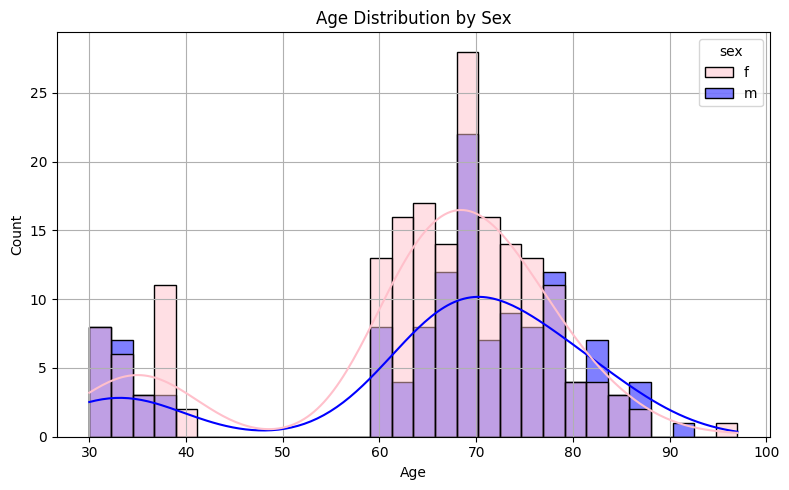

In [36]:
# plot_age_distribution(train_subset)

In [41]:
# def visualize_client_distribution(label_ls, dataset, num_partitions=10, num_samples=None, overlap=0.6, global_bin_pool=None):
#     # Làm sạch dữ liệu gốc
#     label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')
#     label_ls = label_ls.dropna(subset=['subject_age'])

#     # Thêm cột phân biệt nguồn gốc
#     original_df = pd.DataFrame({
#         "age": label_ls["subject_age"],
#         "partition": "Original"
#     })
    
#     all_dfs = []

#     for i in range(num_partitions):
#         subset, _ = load_client_datasets(
#             partition_id=i, 
#             num_partitions=num_partitions, 
#             dataset=dataset, 
#             num_samples=num_samples,
#             overlap=overlap,
#             global_bin_pool=global_bin_pool
#         )
#         subset_data = []

#         for idx in subset.indices:
#             subject_id = subset.dataset._extract_subject_id(subset.dataset.im_filenames[idx])
#             metadata = subset.dataset.label_ls.get(subject_id, {})
#             age = metadata.get("subject_age")

#             if age is not None and not pd.isna(age):
#                 subset_data.append({"age": age, "partition": f"Client {i}"})

#         if subset_data:
#             df = pd.DataFrame(subset_data)
#             all_dfs.append(df)

#     combined_df = pd.concat(all_dfs, ignore_index=True)
#     compare_df = pd.concat([original_df, combined_df], ignore_index=True)

#     print(f'Số mẫu dữ liệu:{len(combined_df)}')

#     plt.figure(figsize=(12, 7))
    
#     for partition in compare_df["partition"].unique():
#         sub_df = compare_df[compare_df["partition"] == partition]
#         if partition == "Original":
#             sns.kdeplot(sub_df["age"], label="Original", color="black", linewidth=2.5, common_norm=False, fill=True, alpha=0.3)
#         else:
#             sns.kdeplot(sub_df["age"], label=partition, linewidth=1.2, common_norm=False, alpha=0.4)

#     plt.title("KDE of Age Distributions Across Client")
#     plt.xlabel("Age")
#     plt.ylabel("Density")
#     plt.legend(title="Nguồn dữ liệu")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     return combined_df

Số mẫu dữ liệu:3160


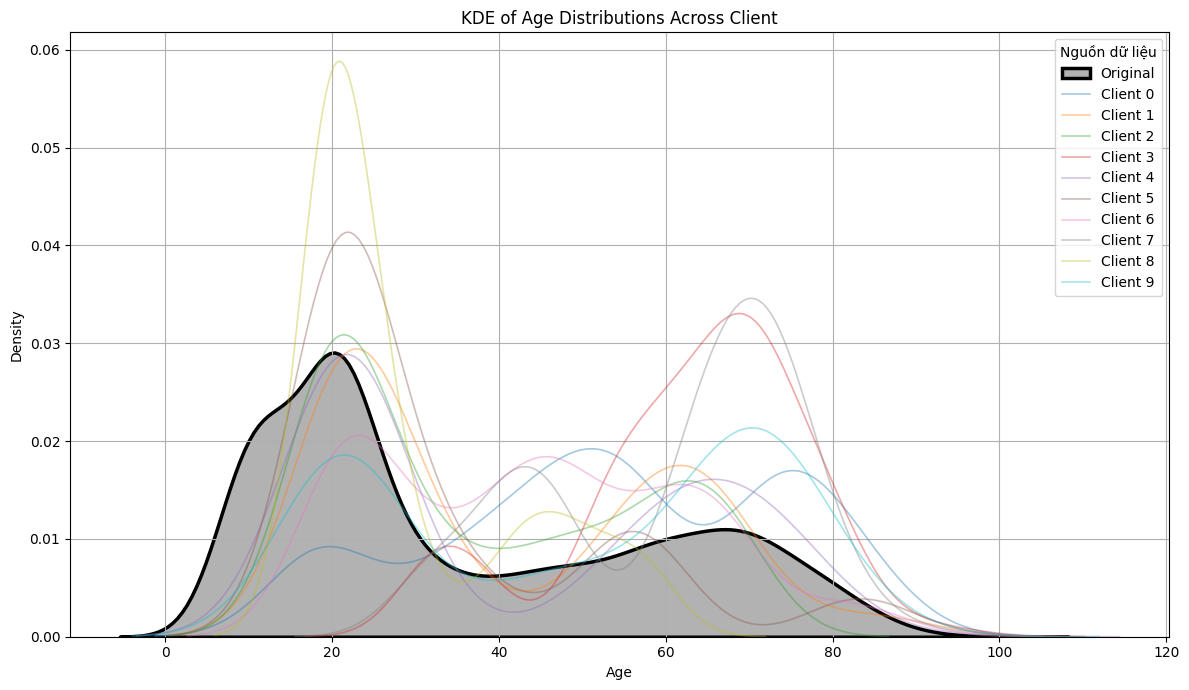

In [42]:
# global_bin_pool = create_global_bin_pool(trainset)
# check_data = visualize_client_distribution(label_ls, trainset, num_partitions=10, overlap=0.7, global_bin_pool=global_bin_pool)

## Model

In [21]:
class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module(
            'conv1',
            nn.Conv3d(num_input_features,
                      bn_size * growth_rate,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module(
            'conv2',
            nn.Conv3d(bn_size * growth_rate,
                      growth_rate,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super().forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features,
                                     p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                                growth_rate, bn_size, drop_rate)
            self.add_module('denselayer{}'.format(i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module(
            'conv',
            nn.Conv3d(num_input_features,
                      num_output_features,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))

class DenseNet(nn.Module):
    def __init__(self,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 growth_rate=32,
                 block_config=(6, 12, 24, 16),
                 num_init_features=64,
                 bn_size=4,
                 drop_rate=0,
                 num_classes=1):
        super().__init__()

        # First convolution
        self.features = [('conv1',
                          nn.Conv3d(n_input_channels,
                                    num_init_features,
                                    kernel_size=(conv1_t_size, 7, 7),
                                    stride=(conv1_t_stride, 2, 2),
                                    padding=(conv1_t_size // 2, 3, 3),
                                    bias=False)),
                         ('norm1', nn.BatchNorm3d(num_init_features)),
                         ('relu1', nn.ReLU(inplace=True))]
        if not no_max_pool:
            self.features.append(
                ('pool1', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)))
        self.features = nn.Sequential(OrderedDict(self.features))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers,
                                num_input_features=num_features,
                                bn_size=bn_size,
                                growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock{}'.format(i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition{}'.format(i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Khởi tạo trọng số
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool3d(out, output_size=(1, 1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [22]:
# Hàm hỗ trợ cho mô hình

# Lấy tham số mô hình
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

# Cập nhật tham số mô hình
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def save_model_parameters(parameters, file_path: str = "final_model.pth"):
    if parameters is None:
        print("No parameters available to save.")
        return
    net = model.to(DEVICE)
    final_ndarrays = parameters_to_ndarrays(parameters)
    set_parameters(net, final_ndarrays)
    torch.save(net.state_dict(), file_path)
    print(f"Model parameters saved to {file_path}")


def train(net, trainloader, epochs: int, lr: float, id: int) -> Tuple[float, float]:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
    net.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"[Client {id} Epoch {epoch+1}/{epochs}]", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).float()
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            
            progress_bar.set_postfix(loss=loss.item())
        
        avg_epoch_loss = epoch_loss / len(trainloader.dataset)
        print(f"[Client {id}] Epoch {epoch+1}/{epochs} - Loss: {avg_epoch_loss:.4f}")
        total_loss += epoch_loss
    
    avg_loss = total_loss / (len(trainloader.dataset) * epochs)
    accuracy = correct / total if total > 0 else 0.0
    print(f"[Client {id}] Train Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

def test(net, testloader, id: int, server_test=False) -> Tuple[float, float]:
    criterion = nn.BCEWithLogitsLoss()
    net.eval()
    loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(testloader, desc=f"[Client {id}] Testing", position=id, leave=False, disable=True)
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE).float()
            outputs = net(images)
            loss += criterion(outputs, labels.unsqueeze(1)).item() * labels.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
            progress_bar.set_postfix(loss=loss/total)
    
    avg_loss = loss / len(testloader.dataset) if len(testloader.dataset) > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    if server_test:
        print(f"[Server Test] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    else:
        print(f"[Client {id}] Test Loss: {avg_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
    return avg_loss, accuracy

In [23]:
model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12))

In [ ]:
# train(model,trainloader,1,0.001)

In [ ]:
# from torchinfo import summary

# summary(model, input_size=(8, 1, 130, 130, 130))

## Reload data

In [ ]:
global_bin_pool = create_global_bin_pool(trainset)

## Client

In [24]:
# dropout
def is_dropout(partition_id: int, num_partitions: int) -> bool:
    return random.random() < DROPOUT

# Định nghĩa Client
class FlowerClient(Client):
    def __init__(self, partition_id, net, trainloader, valloader, num_partitions):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.num_partitions = num_partitions
        self.previous_parameters = None

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.partition_id}] get_parameters")
        ndarrays = get_parameters(self.net)
        parameters = ndarrays_to_parameters(ndarrays)
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(status=status, parameters=parameters)

    def fit(self, ins: FitIns) -> FitRes:
        if is_dropout(self.partition_id, self.num_partitions):
            print(f"[Client {self.partition_id}] dropped out in round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return FitRes(
                status=status,
                parameters=ins.parameters,
                num_examples=0,
                metrics={}
            )
        print(f"[Client {self.partition_id}] fit, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        lr = ins.config.get("lr", 0.001)
        epochs = ins.config.get("epochs", 1)
        train_loss, train_accuracy = train(self.net, self.trainloader, epochs=epochs, lr=lr, id=self.partition_id)

        ndarrays_updated = get_parameters(self.net)
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)
        self.previous_parameters = parameters_updated

        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader.dataset),
            metrics={
                "train_loss": float(train_loss),
                "train_accuracy": float(train_accuracy)
            }
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        if is_dropout(self.partition_id, self.num_partitions):
            print(f"[Client {self.partition_id}] dropped out in evaluation round {ins.config.get('server_round')}")
            status = Status(code=CustomCode.DROPPED_OUT, message="Client dropped out")
            return EvaluateRes(
                status=status,
                loss=0.0,
                num_examples=0,
                metrics={}
            )

        print(f"[Client {self.partition_id}] evaluate, config: {ins.config}")

        ndarrays_original = parameters_to_ndarrays(ins.parameters)
        set_parameters(self.net, ndarrays_original)

        val_loss, val_accuracy = test(self.net, self.valloader, self.partition_id)
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(val_loss),
            num_examples=len(self.valloader.dataset),
            metrics={"val_accuracy": float(val_accuracy)}
        )

# Hàm tạo client
def client_fn(context: Context) -> Client:
    net = model.to(DEVICE)
    partition_id = int(context.node_config["partition-id"])
    num_partitions = context.node_config["num-partitions"]
    
    train_subset, val_subset = load_client_datasets(partition_id, num_partitions, dataset=trainset, overlap=0.6, global_bin_pool=global_bin_pool)
    trainloader = DataLoader(train_subset, batch_size=BATCHSIZE, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=BATCHSIZE, shuffle=False)
    
    return FlowerClient(partition_id, net, trainloader, valloader, num_partitions).to_client()

# Client
client = ClientApp(client_fn=client_fn)

## Strategy server

In [25]:
# Custom Strategy
class FedCustom(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 1,
        min_evaluate_clients: int = 1,
        min_available_clients: int = 1,
        evaluate_fn: Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]] = None
    ):
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn

    def initialize_parameters(self, client_manager: ClientManager) -> Optional[Parameters]:
        net = model
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager) -> List[Tuple[ClientProxy, FitIns]]:
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

        standard_config = {"lr": LR,
                           "epochs": epochs_round,
                           "server_round": server_round}
        fit_configurations = []
        for client in clients:
            fit_configurations.append((client, FitIns(parameters, standard_config)))
        return fit_configurations

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]]
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        if not results:
            return None, {}

        valid_results = [(client_proxy, res) for client_proxy, res in results if res.status.code == Code.OK]
        if not valid_results:
            return None, {}

        weights_results = [
            (parameters_to_ndarrays(res.parameters), res.num_examples)
            for _, res in valid_results
        ]
        parameters_aggregated = ndarrays_to_parameters(
            flwr.server.strategy.aggregate.aggregate(weights_results)
        )

        # save model
        if wandb_log:
            if server_round % 2 == 0:
                save_model_parameters(parameters_aggregated, file_path="final_model.pth")

        total_examples = sum(res.num_examples for _, res in valid_results)
        train_loss_agg = sum(
            res.num_examples * res.metrics["train_loss"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0
        train_accuracy_agg = sum(
            res.num_examples * res.metrics["train_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "train_loss": train_loss_agg,
            "train_accuracy": train_accuracy_agg,
            "clients_participated": len(valid_results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "train_loss": train_loss_agg,
                "train_accuracy": train_accuracy_agg,
                "clients_participated_fit": len(valid_results)
            })

        HISTORY["train_loss"].append(train_loss_agg)
        HISTORY["train_accuracy"].append(train_accuracy_agg)
        HISTORY["clients_participated_fit"].append(len(valid_results))

        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []
        config = {"server_round": server_round}
        evaluate_ins = EvaluateIns(parameters, config)
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]]
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        if not results:
            print(f"Round {server_round}: No results received")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        valid_results = [
            (client_proxy, res) for client_proxy, res in results
            if res.status.code == Code.OK
        ]
        if not valid_results:
            print(f"Round {server_round}: No valid evaluation results")
            return None, {"val_accuracy": 0.0, "clients_participated": 0}

        total_examples = sum(res.num_examples for _, res in valid_results)
        loss_aggregated = flwr.server.strategy.aggregate.weighted_loss_avg(
            [(res.num_examples, res.loss) for _, res in valid_results]
        )
        val_accuracy_aggregated = sum(
            res.num_examples * res.metrics["val_accuracy"] for _, res in valid_results
        ) / total_examples if total_examples > 0 else 0.0

        metrics_aggregated = {
            "val_loss": loss_aggregated,
            "val_accuracy": val_accuracy_aggregated,
            "clients_participated": len(valid_results)
        }

        if wandb_log:
            wandb_logger.log({
                "round": server_round,
                "val_loss": loss_aggregated,
                "val_accuracy": val_accuracy_aggregated,
                "clients_participated_eval": len(valid_results)
            })

        HISTORY["val_loss"].append(loss_aggregated)
        HISTORY["val_accuracy"].append(val_accuracy_aggregated)
        HISTORY["clients_participated_eval"].append(len(valid_results))

        return loss_aggregated, metrics_aggregated

    def evaluate(self, server_round: int, parameters: Parameters) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        if server_round == 0 or self.evaluate_fn is None:
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        return eval_res

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

# Hàm đánh giá trên server
def evaluate_fn(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = model.to(DEVICE)
    set_parameters(net, parameters)
    testloader = load_server_test_datasets(data=testset)
    test_loss, test_accuracy = test(net, testloader, id=-1, server_test=True)

    if wandb_log:
        wandb_logger.log({
            "round": server_round,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy
        })
    
    HISTORY["test_loss"].append(test_loss)
    HISTORY["test_accuracy"].append(test_accuracy)
    
    return test_loss, {"test_accuracy": test_accuracy}

# Server
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedCustom(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=1,
        min_evaluate_clients=1,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn
    )
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

## Training

In [26]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)
wandb_log = True

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nguyenxuanpk357 (nguyentuoc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [29]:
wandb_logger = wandb.init(
    project="Federated Learning",
    name=f"experiment_1",
    config={
        "num_client": NUM_CLIENTS,
        "num_rounds": NUM_ROUNDS,
        "dropout": DROPOUT,
        "learning_rate": LR,
        "architecture": "DenseNet",
        "dataset": "Mri",
        "epochs_round": epochs_round,
    },
)

In [30]:
# Cấu hình backend
backend_config = {"client_resources": {"num_cpus": 2, "num_gpus": 0}}
if DEVICE.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 1

# Khởi tạo HISTORY
HISTORY = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
    "clients_participated_fit": [],
    "clients_participated_eval": []
}

# Chạy simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

wandb_logger.finish()

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=417) 2025-05-07 16:46:05.926901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=417) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=417) E0000 00:00:1746636365.949314     417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=417) E0000 00:00:1746636365.956053     417 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attem

(ClientAppActor pid=417) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=417) [Client 0] Epoch 1/1 - Loss: 0.4947
(ClientAppActor pid=417) [Client 0] Train Loss: 0.4947 | Accuracy: 75.63%
(ClientAppActor pid=416) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=417) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=417) [Client 2] Epoch 1/1 - Loss: 0.5318 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=417) [Client 2] Train Loss: 0.5318 | Accuracy: 72.47% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 1}
(ClientAppActor pid=417) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'se

INFO :      aggregate_fit: received 9 results and 1 failures


(ClientAppActor pid=417) [Client 7] Epoch 1/1 - Loss: 0.5544 [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 7] Train Loss: 0.5544 | Accuracy: 69.62% [repeated 2x across cluster]


INFO :      fit progress: (1, 0.9045781141579753, {'test_accuracy': 0.4393939393939394}, 547.086911474)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.9046 | Accuracy: 43.94%
(ClientAppActor pid=417) [Client 1] evaluate, config: {'server_round': 1}
(ClientAppActor pid=416) [Client 2] Test Loss: 0.9678 | Accuracy: 37.97%
(ClientAppActor pid=416) [Client 2] evaluate, config: {'server_round': 1}
(ClientAppActor pid=416) [Client 4] evaluate, config: {'server_round': 1}
(ClientAppActor pid=417) [Client 5] Test Loss: 0.8892 | Accuracy: 45.57% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 5] evaluate, config: {'server_round': 1}
(ClientAppActor pid=417) [Client 6] dropped out in evaluation round 1
(ClientAppActor pid=417) [Client 7] evaluate, config: {'server_round': 1}
(ClientAppActor pid=417) [Client 7] Test Loss: 0.8564 | Accuracy: 48.10% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 8] evaluate, config: {'server_round': 1}
(ClientAppActor pid=417) [Client 9] dropped out in evaluation round 1
(ClientAppActor pid=417) [Client 3] evaluate, config: {'server_round': 1}
(ClientAppActo

INFO :      aggregate_evaluate: received 8 results and 2 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=417) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=416) [Client 0] Test Loss: 0.8650 | Accuracy: 46.84%
(ClientAppActor pid=417) [Client 2] Epoch 1/1 - Loss: 0.5050
(ClientAppActor pid=417) [Client 2] Train Loss: 0.5050 | Accuracy: 77.22%
(ClientAppActor pid=416) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=417) [Client 3] dropped out in round 2
(ClientAppActor pid=417) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=416) [Client 1] Epoch 1/1 - Loss: 0.4660
(ClientAppActor pid=416) [Client 1] Train Loss: 0.4660 | Accuracy: 79.43%
(ClientAppActor pid=416) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 2}
(ClientAppActor pid=417) [Client 4] Epoch 1/1 - Loss: 0.4456
(ClientAppActor pid=417) [Client 4] Train Loss: 0.4456 | Accuracy: 81.96%
(ClientAppActor pid=417) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=417) [Client 0] Epoch 1/1 - Loss: 0.4749
(ClientAppActor pid=417) [Client 0] Train Loss: 0.4749 | Accuracy: 76.90%


INFO :      fit progress: (2, 0.742730357008751, {'test_accuracy': 0.5595959595959596}, 1006.8227384569999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.7427 | Accuracy: 55.96%
(ClientAppActor pid=417) [Client 0] evaluate, config: {'server_round': 2}
(ClientAppActor pid=417) [Client 0] Test Loss: 0.6440 | Accuracy: 65.82%
(ClientAppActor pid=416) [Client 1] evaluate, config: {'server_round': 2}
(ClientAppActor pid=417) [Client 2] evaluate, config: {'server_round': 2}
(ClientAppActor pid=417) [Client 2] Test Loss: 0.7502 | Accuracy: 55.70% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 4] evaluate, config: {'server_round': 2}
(ClientAppActor pid=417) [Client 5] dropped out in evaluation round 2
(ClientAppActor pid=417) [Client 6] evaluate, config: {'server_round': 2}
(ClientAppActor pid=417) [Client 6] Test Loss: 0.8117 | Accuracy: 51.90% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 9] dropped out in evaluation round 2 [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 8] evaluate, config: {'server_round': 2}
(ClientAppActor pid=417) [Client 3] evaluate, config: {'ser

INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=417) [Client 3] Test Loss: 0.6988 | Accuracy: 60.76%
(ClientAppActor pid=416) [Client 9] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=417) [Client 8] dropped out in round 3
(ClientAppActor pid=417) [Client 0] Epoch 1/1 - Loss: 0.3967
(ClientAppActor pid=417) [Client 0] Train Loss: 0.3967 | Accuracy: 83.54%
(ClientAppActor pid=417) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=417) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=417) [Client 1] Epoch 1/1 - Loss: 0.4412 [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 1] Train Loss: 0.4412 | Accuracy: 79.43% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=417) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 3}
(ClientAppActor pid=416) [Client 3] Epoch 1/1 - Loss: 0.4870
(Cli

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=417) [Client 7] Epoch 1/1 - Loss: 0.4496
(ClientAppActor pid=417) [Client 7] Train Loss: 0.4496 | Accuracy: 80.38%


INFO :      fit progress: (3, 1.0063018677812634, {'test_accuracy': 0.43737373737373736}, 1344.2251675429998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 1.0063 | Accuracy: 43.74%
(ClientAppActor pid=417) [Client 1] evaluate, config: {'server_round': 3}
(ClientAppActor pid=416) [Client 2] Test Loss: 1.1815 | Accuracy: 34.18%
(ClientAppActor pid=416) [Client 2] evaluate, config: {'server_round': 3}
(ClientAppActor pid=416) [Client 3] evaluate, config: {'server_round': 3}
(ClientAppActor pid=417) [Client 4] Test Loss: 1.0018 | Accuracy: 39.24% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 4] evaluate, config: {'server_round': 3}
(ClientAppActor pid=417) [Client 6] evaluate, config: {'server_round': 3}
(ClientAppActor pid=416) [Client 7] dropped out in evaluation round 3
(ClientAppActor pid=416) [Client 8] dropped out in evaluation round 3
(ClientAppActor pid=417) [Client 6] Test Loss: 1.1038 | Accuracy: 37.97% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 9] evaluate, config: {'server_round': 3}
(ClientAppActor pid=417) [Client 5] evaluate, config: {'server_round': 3}
(ClientAppActo

INFO :      aggregate_evaluate: received 8 results and 2 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=417) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=417) [Client 2] Epoch 1/1 - Loss: 0.4371
(ClientAppActor pid=417) [Client 2] Train Loss: 0.4371 | Accuracy: 78.48%
(ClientAppActor pid=417) [Client 5] Test Loss: 1.1052 | Accuracy: 39.24%
(ClientAppActor pid=416) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=417) [Client 5] dropped out in round 4
(ClientAppActor pid=417) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=416) [Client 7] Epoch 1/1 - Loss: 0.4583 [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 7] Train Loss: 0.4583 | Accuracy: 80.06% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 7] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=416) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 4}
(ClientAppActor pid=417) [Client 0] dropped out in round 4
(Clien

INFO :      aggregate_fit: received 8 results and 2 failures
INFO :      fit progress: (4, 0.6863210918927434, {'test_accuracy': 0.6383838383838384}, 1743.208560267)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.6863 | Accuracy: 63.84%
(ClientAppActor pid=417) [Client 2] evaluate, config: {'server_round': 4}
(ClientAppActor pid=416) [Client 1] Epoch 1/1 - Loss: 0.3859
(ClientAppActor pid=416) [Client 1] Train Loss: 0.3859 | Accuracy: 82.28%
(ClientAppActor pid=417) [Client 2] Test Loss: 0.7231 | Accuracy: 64.56%
(ClientAppActor pid=416) [Client 0] evaluate, config: {'server_round': 4}
(ClientAppActor pid=417) [Client 3] evaluate, config: {'server_round': 4}
(ClientAppActor pid=417) [Client 3] Test Loss: 0.7037 | Accuracy: 62.03% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 4] evaluate, config: {'server_round': 4}
(ClientAppActor pid=417) [Client 5] dropped out in evaluation round 4
(ClientAppActor pid=417) [Client 7] evaluate, config: {'server_round': 4}
(ClientAppActor pid=417) [Client 7] Test Loss: 0.5823 | Accuracy: 68.35% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 8] evaluate, config: {'server_round': 4}
(ClientAppActor pid=417

INFO :      aggregate_evaluate: received 9 results and 1 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=417) [Client 6] Test Loss: 0.7099 | Accuracy: 58.23% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 2] dropped out in round 5
(ClientAppActor pid=416) [Client 9] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=416) [Client 9] Epoch 1/1 - Loss: 0.3977
(ClientAppActor pid=416) [Client 9] Train Loss: 0.3977 | Accuracy: 83.23%
(ClientAppActor pid=417) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=416) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5}
(ClientAppActor pid=417) [Client 3] dropped out in round 5
(ClientAppActor pid=417) [Client 4] dropped out in round 5
(ClientAppActor pid=416) [Client 1] Epoch 1/1 - Loss: 0.3503 [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 1] Train Loss: 0.3503 | Accuracy: 84.18% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 5}
(ClientAppAct

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=416) [Client 8] Epoch 1/1 - Loss: 0.3827
(ClientAppActor pid=416) [Client 8] Train Loss: 0.3827 | Accuracy: 83.86%


INFO :      fit progress: (5, 1.0183774128706768, {'test_accuracy': 0.43737373737373736}, 2060.557696203)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 1.0184 | Accuracy: 43.74%
(ClientAppActor pid=417) [Client 2] dropped out in evaluation round 5
(ClientAppActor pid=416) [Client 1] evaluate, config: {'server_round': 5}
(ClientAppActor pid=417) [Client 4] dropped out in evaluation round 5
(ClientAppActor pid=417) [Client 5] dropped out in evaluation round 5
(ClientAppActor pid=417) [Client 6] dropped out in evaluation round 5
(ClientAppActor pid=417) [Client 7] dropped out in evaluation round 5
(ClientAppActor pid=416) [Client 1] Test Loss: 1.0800 | Accuracy: 40.51%
(ClientAppActor pid=417) [Client 8] evaluate, config: {'server_round': 5}
(ClientAppActor pid=416) [Client 9] evaluate, config: {'server_round': 5}
(ClientAppActor pid=417) [Client 0] dropped out in evaluation round 5
(ClientAppActor pid=417) [Client 3] dropped out in evaluation round 5


INFO :      aggregate_evaluate: received 3 results and 7 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=416) [Client 9] Test Loss: 1.1800 | Accuracy: 27.85% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=416) [Client 0] dropped out in round 6
(ClientAppActor pid=416) [Client 3] dropped out in round 6
(ClientAppActor pid=417) [Client 1] Epoch 1/1 - Loss: 0.3965
(ClientAppActor pid=417) [Client 1] Train Loss: 0.3965 | Accuracy: 82.28%
(ClientAppActor pid=416) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=417) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppActor pid=416) [Client 4] Epoch 1/1 - Loss: 0.4445
(ClientAppActor pid=416) [Client 4] Train Loss: 0.4445 | Accuracy: 80.06%
(ClientAppActor pid=416) [Client 7] dropped out in round 6
(ClientAppActor pid=416) [Client 8] dropped out in round 6
(ClientAppActor pid=416) [Client 9] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 6}
(ClientAppAc

INFO :      aggregate_fit: received 6 results and 4 failures


(ClientAppActor pid=416) [Client 2] Epoch 1/1 - Loss: 0.3409
(ClientAppActor pid=416) [Client 2] Train Loss: 0.3409 | Accuracy: 84.49%


INFO :      fit progress: (6, 0.7182843827840054, {'test_accuracy': 0.6484848484848484}, 2317.5227674909997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.7183 | Accuracy: 64.85%
(ClientAppActor pid=417) [Client 5] evaluate, config: {'server_round': 6}
(ClientAppActor pid=416) [Client 1] Test Loss: 0.5870 | Accuracy: 77.22%
(ClientAppActor pid=416) [Client 1] evaluate, config: {'server_round': 6}
(ClientAppActor pid=416) [Client 8] evaluate, config: {'server_round': 6}
(ClientAppActor pid=417) [Client 2] Test Loss: 0.6207 | Accuracy: 62.03% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 2] evaluate, config: {'server_round': 6}
(ClientAppActor pid=417) [Client 3] evaluate, config: {'server_round': 6}
(ClientAppActor pid=416) [Client 4] Test Loss: 0.7021 | Accuracy: 62.03% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 4] evaluate, config: {'server_round': 6}
(ClientAppActor pid=416) [Client 7] evaluate, config: {'server_round': 6}
(ClientAppActor pid=416) [Client 7] Test Loss: 0.5853 | Accuracy: 65.82% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 9] evaluate, config

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=417) [Client 6] Test Loss: 0.6716 | Accuracy: 58.23% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 6] evaluate, config: {'server_round': 6}
(ClientAppActor pid=417) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=417) [Client 6] Epoch 1/1 - Loss: 0.3972
(ClientAppActor pid=417) [Client 6] Train Loss: 0.3972 | Accuracy: 83.86%
(ClientAppActor pid=416) [Client 0] Test Loss: 0.6499 | Accuracy: 67.09%
(ClientAppActor pid=416) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=417) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=417) [Client 1] Epoch 1/1 - Loss: 0.3307 [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 1] Train Loss: 0.3307 | Accuracy: 85.76% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 7}
(ClientAppActor pid=417) [Client 3] fit, co

INFO :      aggregate_fit: received 8 results and 2 failures
INFO :      fit progress: (7, 0.7921091680574899, {'test_accuracy': 0.5494949494949495}, 2725.3558862269997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.7921 | Accuracy: 54.95%
(ClientAppActor pid=417) [Client 0] evaluate, config: {'server_round': 7}
(ClientAppActor pid=417) [Client 9] Epoch 1/1 - Loss: 0.4079
(ClientAppActor pid=417) [Client 9] Train Loss: 0.4079 | Accuracy: 83.23%
(ClientAppActor pid=416) [Client 1] dropped out in evaluation round 7
(ClientAppActor pid=416) [Client 2] Test Loss: 0.9049 | Accuracy: 46.84%
(ClientAppActor pid=416) [Client 2] evaluate, config: {'server_round': 7}
(ClientAppActor pid=416) [Client 3] dropped out in evaluation round 7
(ClientAppActor pid=416) [Client 4] dropped out in evaluation round 7
(ClientAppActor pid=417) [Client 5] evaluate, config: {'server_round': 7}
(ClientAppActor pid=417) [Client 5] Test Loss: 0.8514 | Accuracy: 54.43% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 6] evaluate, config: {'server_round': 7}
(ClientAppActor pid=417) [Client 7] evaluate, config: {'server_round': 7}
(ClientAppActor pid=416) [Client 9] Test Loss: 0.8962 | Acc

INFO :      aggregate_evaluate: received 6 results and 4 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=417) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=416) [Client 2] Epoch 1/1 - Loss: 0.4130
(ClientAppActor pid=416) [Client 2] Train Loss: 0.4130 | Accuracy: 81.01%
(ClientAppActor pid=417) [Client 7] Test Loss: 0.6855 | Accuracy: 59.49%
(ClientAppActor pid=416) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=416) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=417) [Client 5] dropped out in round 8
(ClientAppActor pid=417) [Client 6] Epoch 1/1 - Loss: 0.3803 [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 6] Train Loss: 0.3803 | Accuracy: 85.76% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 6] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(ClientAppActor pid=417) [Client 7] dropped out in round 8
(ClientAppActor pid=417) [Client 8] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 8}
(Clien

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=417) [Client 4] Epoch 1/1 - Loss: 0.3233 [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 4] Train Loss: 0.3233 | Accuracy: 88.61% [repeated 2x across cluster]


INFO :      fit progress: (8, 0.7870634977263634, {'test_accuracy': 0.6565656565656566}, 3029.552471207)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.7871 | Accuracy: 65.66%
(ClientAppActor pid=417) [Client 0] evaluate, config: {'server_round': 8}
(ClientAppActor pid=416) [Client 7] Test Loss: 0.5709 | Accuracy: 73.42%
(ClientAppActor pid=416) [Client 7] evaluate, config: {'server_round': 8}
(ClientAppActor pid=416) [Client 4] evaluate, config: {'server_round': 8}
(ClientAppActor pid=417) [Client 5] dropped out in evaluation round 8
(ClientAppActor pid=416) [Client 4] Test Loss: 0.6359 | Accuracy: 68.35% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 6] evaluate, config: {'server_round': 8}
(ClientAppActor pid=416) [Client 8] dropped out in evaluation round 8
(ClientAppActor pid=416) [Client 1] evaluate, config: {'server_round': 8}


INFO :      aggregate_evaluate: received 5 results and 5 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=416) [Client 1] Test Loss: 0.9872 | Accuracy: 65.82% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 3] dropped out in evaluation round 8 [repeated 3x across cluster]
(ClientAppActor pid=416) [Client 0] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=417) [Client 3] Epoch 1/1 - Loss: 0.3815
(ClientAppActor pid=417) [Client 3] Train Loss: 0.3815 | Accuracy: 81.96%
(ClientAppActor pid=417) [Client 3] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=417) [Client 4] dropped out in round 9
(ClientAppActor pid=417) [Client 5] dropped out in round 9
(ClientAppActor pid=417) [Client 6] dropped out in round 9
(ClientAppActor pid=417) [Client 7] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 9}
(ClientAppActor pid=416) [Client 0] Epoch 1/1 - Loss: 0.3555
(ClientAppActor pid=416) [Client 0] Train Loss: 0.3555 | Accuracy: 85.76%
(ClientAppActor pid=416) [Client 8] dropped out in round 9
(ClientA

INFO :      aggregate_fit: received 6 results and 4 failures
INFO :      fit progress: (9, 1.196882100538774, {'test_accuracy': 0.43434343434343436}, 3302.9455088189998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 1.1969 | Accuracy: 43.43%
(ClientAppActor pid=417) [Client 0] evaluate, config: {'server_round': 9}
(ClientAppActor pid=417) [Client 2] Epoch 1/1 - Loss: 0.3520
(ClientAppActor pid=417) [Client 2] Train Loss: 0.3520 | Accuracy: 86.39%
(ClientAppActor pid=416) [Client 2] Test Loss: 1.3854 | Accuracy: 32.91%
(ClientAppActor pid=416) [Client 2] evaluate, config: {'server_round': 9}
(ClientAppActor pid=416) [Client 4] dropped out in evaluation round 9
(ClientAppActor pid=416) [Client 5] evaluate, config: {'server_round': 9}
(ClientAppActor pid=417) [Client 6] Test Loss: 1.3728 | Accuracy: 40.51% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 6] evaluate, config: {'server_round': 9}
(ClientAppActor pid=417) [Client 7] evaluate, config: {'server_round': 9}
(ClientAppActor pid=417) [Client 7] Test Loss: 1.1972 | Accuracy: 48.10% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 8] evaluate, config: {'server_round': 9}
(ClientAppActor pid=416

INFO :      aggregate_evaluate: received 9 results and 1 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=417) [Client 1] Test Loss: 0.9187 | Accuracy: 50.63% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 1] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=417) [Client 1] Epoch 1/1 - Loss: 0.3555
(ClientAppActor pid=417) [Client 1] Train Loss: 0.3555 | Accuracy: 84.49%
(ClientAppActor pid=416) [Client 2] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=417) [Client 3] dropped out in round 10
(ClientAppActor pid=417) [Client 4] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=417) [Client 4] Epoch 1/1 - Loss: 0.3392 [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 4] Train Loss: 0.3392 | Accuracy: 87.97% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 5] fit, config: {'lr': 0.001, 'epochs': 1, 'server_round': 10}
(ClientAppActor pid=417) [Client 7] dropped out in round 10
(ClientAppActor pid=417) [Client 8] fit, config: {'lr': 0.001, 'ep

INFO :      aggregate_fit: received 7 results and 3 failures


(ClientAppActor pid=417) [Client 6] Epoch 1/1 - Loss: 0.4090
(ClientAppActor pid=417) [Client 6] Train Loss: 0.4090 | Accuracy: 82.59%


INFO :      fit progress: (10, 0.7281620475378904, {'test_accuracy': 0.6404040404040404}, 3717.8113162349996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


[Server Test] Test Loss: 0.7282 | Accuracy: 64.04%
(ClientAppActor pid=416) [Client 1] evaluate, config: {'server_round': 10}
(ClientAppActor pid=417) [Client 0] dropped out in evaluation round 10
(ClientAppActor pid=416) [Client 1] Test Loss: 0.7593 | Accuracy: 63.29%
(ClientAppActor pid=417) [Client 2] evaluate, config: {'server_round': 10}
(ClientAppActor pid=416) [Client 3] evaluate, config: {'server_round': 10}
(ClientAppActor pid=417) [Client 4] Test Loss: 0.5457 | Accuracy: 72.15% [repeated 2x across cluster]
(ClientAppActor pid=417) [Client 4] evaluate, config: {'server_round': 10}
(ClientAppActor pid=417) [Client 5] evaluate, config: {'server_round': 10}
(ClientAppActor pid=417) [Client 5] Test Loss: 0.5717 | Accuracy: 72.15% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 7] evaluate, config: {'server_round': 10}
(ClientAppActor pid=417) [Client 9] dropped out in evaluation round 10
(ClientAppActor pid=417) [Client 8] evaluate, config: {'server_round': 10}


INFO :      aggregate_evaluate: received 7 results and 3 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 3750.46s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.9034424898556516
INFO :      		round 2: 0.7156114120703279
INFO :      		round 3: 1.0534966175880613
INFO :      		round 4: 0.6635246290268609
INFO :      		round 5: 1.0710387851115521
INFO :      		round 6: 0.6291776459805573
INFO :      		round 7: 0.8175646274150172
INFO :      		round 8: 0.7311676438850693
INFO :      		round 9: 1.254539684488133
INFO :      		round 10: 0.6665292715832295
INFO :      	History (loss, centralized):
INFO :      		round 1: 0.9045781141579753
INFO :      		round 2: 0.742730357008751
INFO :      		round 3: 1.0063018677812634
INFO :      		round 4: 0.6863210918927434
INFO :      		round 5: 1.0183774128706768
INFO :      		round 6: 0.7182843827840054
INFO :      		round 7: 0.7921091680574899
INFO :      		round 8: 0.7870634977263634
INFO :     

(ClientAppActor pid=417) [Client 8] Test Loss: 0.6866 | Accuracy: 70.89% [repeated 2x across cluster]
(ClientAppActor pid=416) [Client 6] dropped out in evaluation round 10


(pid=416) 2025-05-07 16:46:05.926896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=416) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=416) E0000 00:00:1746636365.949378     416 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=416) E0000 00:00:1746636365.956292     416 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


clients_participated_eval,▆▅▆▇▁█▄▃▇▅
clients_participated_fit,█▃▃▆▃▁▆▃▁▃
round,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇███
test_accuracy,▁▅▁▇▁█▅█▁▇
test_loss,▄▂▅▁▆▁▂▂█▂
train_accuracy,▁▄▅▆▆▆▇██▇
train_loss,█▅▅▄▂▂▁▁▁▂
val_accuracy,▂▆▂▇▁█▅█▂█
val_loss,▄▂▆▁▆▁▃▂█▁
clients_participated_eval,7
clients_participated_fit,7


## Result

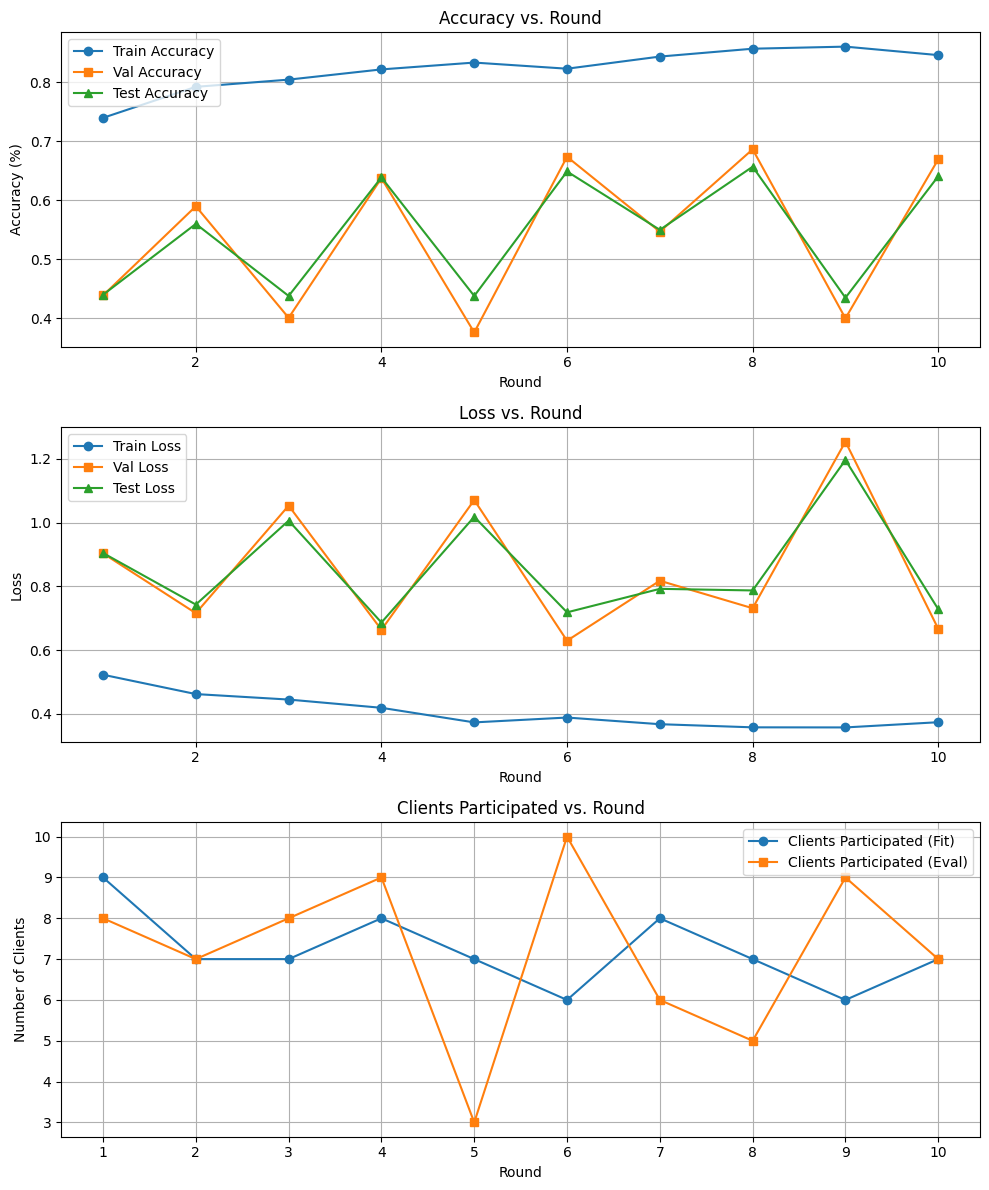

In [31]:
plt.figure(figsize=(10, 12))

# Biểu đồ Accuracy
plt.subplot(3, 1, 1)
plt.plot(range(1, len(HISTORY["train_accuracy"]) + 1), HISTORY["train_accuracy"], label="Train Accuracy", marker='o')
plt.plot(range(1, len(HISTORY["val_accuracy"]) + 1), HISTORY["val_accuracy"], label="Val Accuracy", marker='s')
plt.plot(range(1, len(HISTORY["test_accuracy"]) + 1), HISTORY["test_accuracy"], label="Test Accuracy", marker='^')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Loss
plt.subplot(3, 1, 2)
plt.plot(range(1, len(HISTORY["train_loss"]) + 1), HISTORY["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, len(HISTORY["val_loss"]) + 1), HISTORY["val_loss"], label="Val Loss", marker='s')
plt.plot(range(1, len(HISTORY["test_loss"]) + 1), HISTORY["test_loss"], label="Test Loss", marker='^')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs. Round")
plt.legend()
plt.grid(True)

# Biểu đồ Clients Participated
plt.subplot(3, 1, 3)
plt.plot(range(1, len(HISTORY["clients_participated_fit"]) + 1), HISTORY["clients_participated_fit"], label="Clients Participated (Fit)", marker='o')
plt.plot(range(1, len(HISTORY["clients_participated_eval"]) + 1), HISTORY["clients_participated_eval"], label="Clients Participated (Eval)", marker='s')
plt.xlabel("Round")
plt.ylabel("Number of Clients")
plt.title("Clients Participated vs. Round")
plt.legend()
plt.grid(True)
plt.xticks(range(1, max(len(HISTORY["clients_participated_fit"]), len(HISTORY["clients_participated_eval"])) + 1))

plt.tight_layout()